In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-daraset/Constraint_English_Test - Sheet1.csv
/kaggle/input/covid-daraset/Constraint_English_Val - Sheet1.csv
/kaggle/input/covid-daraset/Constraint_English_Train - Sheet1.csv
/kaggle/input/covid-daraset/english_test_with_labels - Sheet1.csv


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sentence_transformers import SentenceTransformer
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import seaborn as sns
import joblib

In [5]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "Constraint_English_Train - Sheet1.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "omarelmoujahid/covid-daraset",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)



<ipython-input-5-4a3c1a9174d9>:10: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


In [6]:
df_train= pd.read_csv("/kaggle/input/covid-daraset/Constraint_English_Train - Sheet1.csv")
df_train.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [7]:
df_test= pd.read_csv("/kaggle/input/covid-daraset/english_test_with_labels - Sheet1.csv")
df_test.head()

,id,tweet,label
0,1,Our daily update is published. States reported...,real
1,2,Alfalfa is the only cure for COVID-19.,fake
2,3,President Trump Asked What He Would Do If He W...,fake
3,4,States reported 630 deaths. We are still seein...,real
4,5,This is the sixth time a global health emergen...,real


In [8]:
df_val= pd.read_csv("/kaggle/input/covid-daraset/Constraint_English_Val - Sheet1.csv")
df_val.head()

,id,tweet,label
0,1,Chinese converting to Islam after realising th...,fake
1,2,11 out of 13 people (from the Diamond Princess...,fake
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real


In [9]:
data=pd.concat([df_train , df_test],axis=0)

In [10]:
data.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [11]:
data.duplicated().sum()

0

In [37]:
train_text = data["tweet"].reset_index(drop=True)
train_labels = data["label"].reset_index(drop=True)
test_text = df_test["tweet"].reset_index(drop=True)
test_labels = df_test["label"].reset_index(drop=True)

In [38]:
train_text

0       The CDC currently reports 99031 deaths. In gen...
1       States reported 1121 deaths a small rise from ...
2       Politically Correct Woman (Almost) Uses Pandem...
3       #IndiaFightsCorona: We have 1524 #COVID testin...
4       Populous states can generate large case counts...
                              ...                        
8555    #CoronaVirusUpdates: State-wise details of Tot...
8556    Tonight 12(midnight) onwards Disaster Manageme...
8557    296 new cases of #COVID19Nigeria; Plateau-85 E...
8558    RT @CDCemergency: #DYK? @CDCgov’s One-Stop Sho...
8559    More than half of pregnant women recently admi...
Name: tweet, Length: 8560, dtype: object

In [39]:
train_labels.head()

0    real
1    real
2    fake
3    real
4    real
Name: label, dtype: object

In [40]:
train_labels = np.where(train_labels=="real",1,0)

In [47]:
train_labels.dtype

dtype('int64')

In [42]:
print(train_labels.shape , train_text.shape)

(8560,) (8560,)


In [43]:
test_labels = np.where(test_labels=="real",1,0)

In [44]:
print(test_labels.shape , test_text.shape)

(2140,) (2140,)


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("i m using " ,device)

i m using  cuda


In [15]:
#loading widght
sbert_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2").to(device)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [48]:
#Generate SBERT Embeddings
def get_sbert_embeddings(texts, model):
    return model.encode(texts, convert_to_numpy=True)

X_train = get_sbert_embeddings(train_text,sbert_model)
X_test = get_sbert_embeddings(test_text, sbert_model)

y_train = np.array(train_labels)
y_test = np.array(test_labels)

Batches:   0%|          | 0/268 [00:00<?, ?it/s]

Batches:   0%|          | 0/67 [00:00<?, ?it/s]

In [49]:
#Create Dataset and DataLoader
class TheDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [50]:
train_dataset = TheDataset(X_train, y_train)
test_dataset = TheDataset(X_test, y_test)

In [51]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [52]:
class SBERTClassifier(nn.Module):
    def __init__(self, embedding_dim=384, num_classes=2, use_softmax=True):
        super(SBERTClassifier, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)
        self.softmax = nn.Softmax(dim=1) if use_softmax else nn.Identity()  

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.softmax(x)

In [53]:
#  Train Model
def train_model(model, train_loader, test_loader, epochs=10, learning_rate=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, test_losses = [], []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))

        # Evaluate on test set
        model.eval()
        test_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()

                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(y_batch.cpu().numpy())

        test_losses.append(test_loss / len(test_loader))
        accuracy = accuracy_score(all_labels, all_preds)
        print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Test Loss={test_losses[-1]:.4f}, Accuracy={accuracy:.4f}")

    return model, train_losses, test_losses

In [54]:
model_softmax = SBERTClassifier(use_softmax=True)
print("\nTraining with Softmax...")
model_softmax, train_losses_softmax, test_losses_softmax = train_model(model_softmax, train_loader, test_loader)
model_logits= SBERTClassifier(use_softmax=False)
print("\nTraining without Softmax (Logits)...")
model_logits, train_losses_logits, test_losses_logits = train_model(model_logits, train_loader, test_loader)

#  Save the Model
torch.save(model_softmax.state_dict(), "sbert_classifier_softmax.pth")
torch.save(model_logits.state_dict(), "sbert_classifier_logits.pth")
joblib.dump(sbert_model, "sbert_model.pkl")
#  Evaluate and plot



Training with Softmax...


Epoch 1/10: 100%|██████████| 268/268 [00:00<00:00, 448.67it/s]


Epoch 1: Train Loss=0.4592, Test Loss=0.4059, Accuracy=0.9093


Epoch 2/10: 100%|██████████| 268/268 [00:00<00:00, 651.96it/s]


Epoch 2: Train Loss=0.3966, Test Loss=0.3928, Accuracy=0.9210


Epoch 3/10: 100%|██████████| 268/268 [00:00<00:00, 664.16it/s]


Epoch 3: Train Loss=0.3883, Test Loss=0.3906, Accuracy=0.9215


Epoch 4/10: 100%|██████████| 268/268 [00:00<00:00, 675.19it/s]


Epoch 4: Train Loss=0.3836, Test Loss=0.3823, Accuracy=0.9308


Epoch 5/10: 100%|██████████| 268/268 [00:00<00:00, 688.41it/s]


Epoch 5: Train Loss=0.3787, Test Loss=0.3769, Accuracy=0.9360


Epoch 6/10: 100%|██████████| 268/268 [00:00<00:00, 675.73it/s]


Epoch 6: Train Loss=0.3753, Test Loss=0.3753, Accuracy=0.9379


Epoch 7/10: 100%|██████████| 268/268 [00:00<00:00, 624.84it/s]


Epoch 7: Train Loss=0.3727, Test Loss=0.3726, Accuracy=0.9421


Epoch 8/10: 100%|██████████| 268/268 [00:00<00:00, 638.70it/s]


Epoch 8: Train Loss=0.3706, Test Loss=0.3763, Accuracy=0.9346


Epoch 9/10: 100%|██████████| 268/268 [00:00<00:00, 627.05it/s]


Epoch 9: Train Loss=0.3670, Test Loss=0.3644, Accuracy=0.9523


Epoch 10/10: 100%|██████████| 268/268 [00:00<00:00, 670.67it/s]


Epoch 10: Train Loss=0.3655, Test Loss=0.3668, Accuracy=0.9481

Training without Softmax (Logits)...


Epoch 1/10: 100%|██████████| 268/268 [00:00<00:00, 652.36it/s]


Epoch 1: Train Loss=0.3016, Test Loss=0.2190, Accuracy=0.9121


Epoch 2/10: 100%|██████████| 268/268 [00:00<00:00, 675.62it/s]


Epoch 2: Train Loss=0.2010, Test Loss=0.1860, Accuracy=0.9220


Epoch 3/10: 100%|██████████| 268/268 [00:00<00:00, 681.86it/s]


Epoch 3: Train Loss=0.1818, Test Loss=0.1698, Accuracy=0.9322


Epoch 4/10: 100%|██████████| 268/268 [00:00<00:00, 669.65it/s]


Epoch 4: Train Loss=0.1609, Test Loss=0.1459, Accuracy=0.9435


Epoch 5/10: 100%|██████████| 268/268 [00:00<00:00, 665.54it/s]


Epoch 5: Train Loss=0.1439, Test Loss=0.1296, Accuracy=0.9491


Epoch 6/10: 100%|██████████| 268/268 [00:00<00:00, 695.51it/s]


Epoch 6: Train Loss=0.1274, Test Loss=0.1101, Accuracy=0.9636


Epoch 7/10: 100%|██████████| 268/268 [00:00<00:00, 683.47it/s]


Epoch 7: Train Loss=0.1139, Test Loss=0.1014, Accuracy=0.9696


Epoch 8/10: 100%|██████████| 268/268 [00:00<00:00, 666.15it/s]


Epoch 8: Train Loss=0.0995, Test Loss=0.0853, Accuracy=0.9701


Epoch 9/10: 100%|██████████| 268/268 [00:00<00:00, 684.03it/s]


Epoch 9: Train Loss=0.0869, Test Loss=0.0891, Accuracy=0.9668


Epoch 10/10: 100%|██████████| 268/268 [00:00<00:00, 654.86it/s]


Epoch 10: Train Loss=0.0757, Test Loss=0.0696, Accuracy=0.9771

Evaluation with Softmax:


NameError: name 'evaluate_model' is not defined

In [56]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


Evaluation with Softmax:

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1020
           1       0.97      0.93      0.95      1120

    accuracy                           0.95      2140
   macro avg       0.95      0.95      0.95      2140
weighted avg       0.95      0.95      0.95      2140



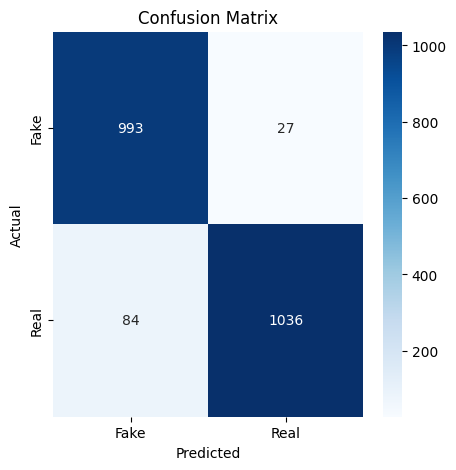


Evaluation without Softmax:

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1020
           1       1.00      0.96      0.98      1120

    accuracy                           0.98      2140
   macro avg       0.98      0.98      0.98      2140
weighted avg       0.98      0.98      0.98      2140



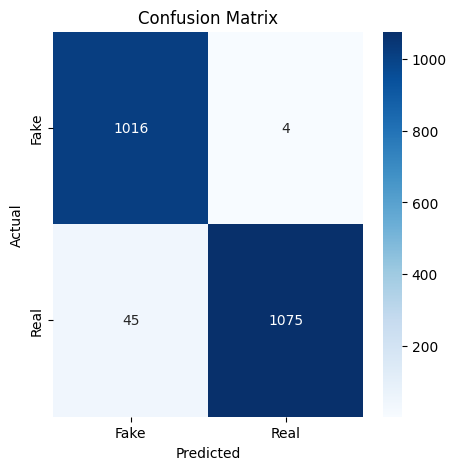

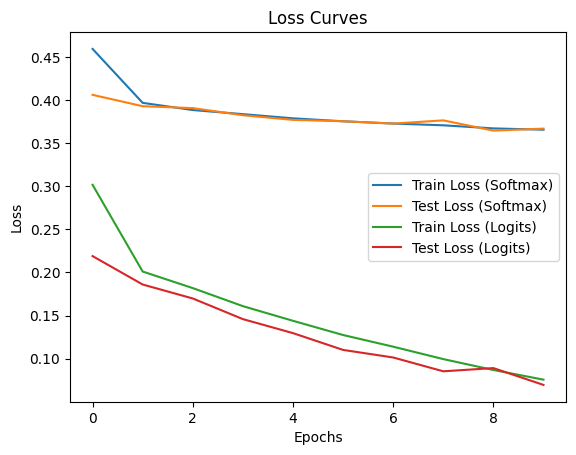

In [57]:
print("\nEvaluation with Softmax:")
evaluate_model(model_softmax, test_loader)

print("\nEvaluation without Softmax:")
evaluate_model(model_logits, test_loader)

# Plot Training Loss Curves
plt.plot(train_losses_softmax, label="Train Loss (Softmax)")
plt.plot(test_losses_softmax, label="Test Loss (Softmax)")
plt.plot(train_losses_logits, label="Train Loss (Logits)")
plt.plot(test_losses_logits, label="Test Loss (Logits)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()